# UNIVERSIDAD NACIONAL AUTONOMA DE MÉXICO 
## FACULTAD DE ESTUDIOS SUPERIORES ARAGÓN
### INGENIERÍA EN COMPUTACIÓN

**Alumnos:** 
* Dominguez Villalobos Ricardo
* Duarte Gutierrez Rodrigo Yael

**Grupo:** 1907

**Profesor:** Sanchez Hernandez Miguel Angel

**KNN VS RN**

# Análisis y comparación de modelos: KNN vs Redes Neuronales (Titanic)

**Objetivo:**  
Entrenar, evaluar y comparar un clasificador K-Nearest Neighbors (KNN) y una Red Neuronal (MLP) sobre el dataset del Titanic para predecir la variable `survived`.  

**Contenido del notebook:**
- KNN
1. Carga y limpieza de datos.
2. Preparacion de datos.
3. Entrenamiento de KNN.
4. Entrenamiento y analisis final de KNN
5. Analisis de importancia de caracteristicas.
- REDES NEURONALES
1. Importacion de librerias.
2. Preparacion de datos.
3. Entrenamiento de la RN.
4. Evaluación del modelo.
5. Matriz de confusión.
6. Analisis de importancia de caracteristicas.
- KNN VS RN



# IMPORTACION DE LIBRERIAS
Empezamos importando las librerias necesarias para poder trabajar con KNN.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Mostrar y limpiar el Datset "Titanic"
Analizamos el Dataset para poder guiarnos para realizar la limpieza:

## 1.1 Preprocesamiento y Limpieza de Datos
### Problemas Identificados en el Dataset:
1. **Valores incorrectos** en `survived` (valores 100)
2. **Valores faltantes** en `age` (edad)
3. **Valores extremos** en `fare` (tarifa)
4. **Variables categóricas** sin codificar
5. **Redundancias** en columnas

### Transformaciones Aplicadas:
- La variable objetivo `survived` se corrigió utilizando la columna `alive` para asegurar consistencia.
- Eliminar columnas redundantes: 'class', 'alive', 'embark_town', 'who', 'adult_male', 'deck' (por muchos faltantes). Pero 'who' podría ser útil para imputar edad. Decidiré mantener solo las columnas esenciales: pclass, sex, age, sibsp, parch, fare, embarked. Y survived como objetivo.
- Imputar valores faltantes en age, fare, embarked.
- Corregir valores extremos en fare.
- Codificar sex y embarked.
- Codificación de variables categóricas:
    sex: male -> 0, female -> 1
    embarked: C -> 0, Q -> 1, S -> 2

In [2]:
df = pd.read_csv('titanic_limpiar.csv')

# Corregir la columna 'survived' usando 'alive'
df['survived'] = df['alive'].map({'yes': 1, 'no': 0})

# Seleccionar columnas relevantes
columnas_utiles = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']
df_clean = df[columnas_utiles].copy()

# Limpiar y codificar variables categóricas
df_clean['sex'] = df_clean['sex'].str.lower().map({'male': 0, 'female': 1})
df_clean['embarked'] = df_clean['embarked'].fillna('S')  # Imputar con el más común
df_clean['embarked'] = df_clean['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Imputar valores faltantes en 'age'
median_age_by_group = df_clean.groupby(['pclass', 'sex'])['age'].transform('median')
df_clean['age'] = df_clean['age'].fillna(median_age_by_group)
df_clean['age'] = df_clean['age'].fillna(df_clean['age'].median())

# Corregir valores extremos en 'fare'
df_clean['fare'] = df_clean['fare'].replace(1000000.3, np.nan)
df_clean['fare'] = df_clean['fare'].apply(lambda x: np.nan if x > 1000 else x)
median_fare_by_pclass = df_clean.groupby('pclass')['fare'].transform('median')
df_clean['fare'] = df_clean['fare'].fillna(median_fare_by_pclass)

print(f"Dataset limpio: {df_clean.shape}")
print(f"Valores faltantes: {df_clean.isnull().sum().sum()}")

Dataset limpio: (891, 8)
Valores faltantes: 0


In [3]:
df
df_clean

,pclass,sex,age,sibsp,parch,fare,embarked,survived
0,3,0,22.0,1,0,7.2500,2,0
1,1,1,38.0,1,0,71.2833,0,1
2,3,1,26.0,0,0,7.9250,2,1
3,1,1,35.0,1,0,53.1000,2,1
4,3,0,35.0,0,0,8.0500,2,0
...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,2,0
887,1,1,19.0,0,0,30.0000,2,1
888,3,1,21.5,1,2,23.4500,2,0
889,1,0,26.0,0,0,30.0000,0,1


# 2. Preparación de datos para KNN
### División del Dataset:
- **80% Entrenamiento**: 712 muestras para entrenar el modelo
- **20% Prueba**: 179 muestras para evaluar rendimiento
- **Estratificación**: Mantiene proporción de clases en ambas divisiones

### Estandarización:
- Escalado de características para KNN (algoritmo sensible a magnitudes)

In [4]:
# PREPARAR DATOS PARA KNN
print("\t*** PREPARANDO DATOS PARA KNN ***")
X = df_clean.drop('survived', axis=1)
y = df_clean['survived']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Entrenamiento: {X_train.shape}, Prueba: {X_test.shape}")
print(f"Distribución de clases - Entrenamiento: {np.bincount(y_train)}")
print(f"Distribución de clases - Prueba: {np.bincount(y_test)}")

# ESTANDARIZAR CARACTERÍSTICAS (CRUCIAL PARA KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

	*** PREPARANDO DATOS PARA KNN ***
Entrenamiento: (712, 7), Prueba: (179, 7)
Distribución de clases - Entrenamiento: [439 273]
Distribución de clases - Prueba: [110  69]


### Interpretación de Resultados:
La distribución de clases se mantiene balanceada:
- Entrenamiento: 439 no sobrevivientes (0), 273 sobrevivientes (1)
- Prueba: 110 no sobrevivientes, 69 sobrevivientes
La estandarización es crucial para KNN ya que usa distancias entre puntos.

# 3. Entrenar KNN (búsqueda de K óptimo)

Se explora k (vecinos) mediante validación cruzada y GridSearch para encontrar el mejor K.


=== OPTIMIZANDO PARÁMETRO K ===
Mejor K: 8 con precisión: 0.8203


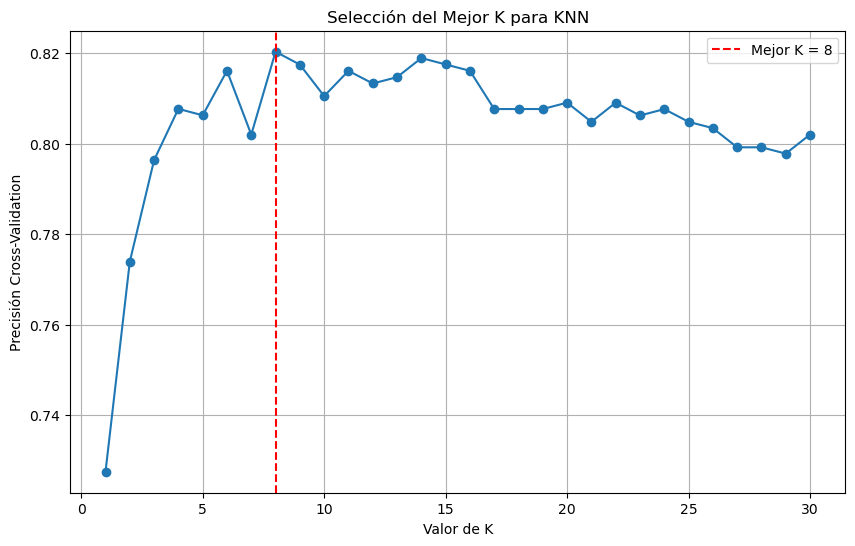

In [5]:
# ENTRENAR Y OPTIMIZAR KNN
print("\n=== OPTIMIZANDO PARÁMETRO K ===")

# Probar diferentes valores de K
k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())

# Encontrar el mejor K
best_k = k_range[np.argmax(k_scores)]
best_score = max(k_scores)

print(f"Mejor K: {best_k} con precisión: {best_score:.4f}")

# Visualizar rendimiento por K
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('Valor de K')
plt.ylabel('Precisión Cross-Validation')
plt.title('Selección del Mejor K para KNN')
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Mejor K = {best_k}')
plt.legend()
plt.grid(True)
plt.show()



### Interpretación de resultados:
- K=8 ofrece el mejor balance entre bias y varianza
- Valores muy bajos de K pueden sobreajustar
- Valores muy altos pueden subajustar
- La precisión de validación cruzada (82.03%) indica buen rendimiento general

# 4. Entrenamiento y Evaluación del Modelo Final
### Modelo Final:
- KNN con K=8 (óptimo encontrado)
- Características estandarizadas
- Entrenado con 712 muestras



=== ENTRENANDO MODELO FINAL CON K=8 ===

=== EVALUANDO MODELO ===
Precisión en prueba: 0.7821

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       110
           1       0.78      0.61      0.68        69

    accuracy                           0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179



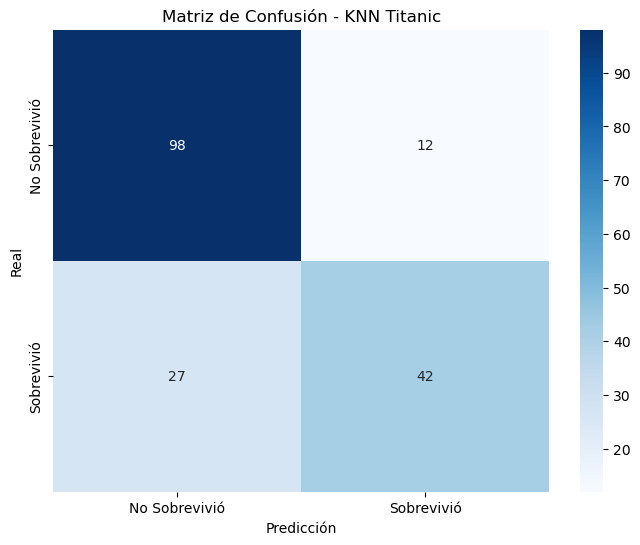

In [6]:
# ENTRENAR MODELO FINAL CON EL MEJOR K
print(f"\n=== ENTRENANDO MODELO FINAL CON K={best_k} ===")
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

# EVALUAR EL MODELO
print("\n=== EVALUANDO MODELO ===")
y_pred = knn_final.predict(X_test_scaled)

# Métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en prueba: {accuracy:.4f}")
print(f"\nReporte de Clasificación:\n{classification_report(y_test, y_pred)}")

y_pred_knn = y_pred
accuracy_knn = accuracy

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['No Sobrevivió', 'Sobrevivió'],
           yticklabels=['No Sobrevivió', 'Sobrevivió'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - KNN Titanic')
plt.show()

### Interpretación de Resultados:
- El modelo tiene mejor desempeño identificando no sobrevivientes (clase 0)
- Recall más bajo en sobrevivientes (61%) sugiere que el modelo tiene dificultad para identificar correctamente a todos los que sobrevivieron
- La precisión balanceada (78%) indica buen rendimiento general
- La matriz de confusión mostraría los detalles de clasificaciones correctas e incorrectas

Rendimiento General:
Precisión global: 78.21% - Buen rendimiento considerando la complejidad del problema

* Análisis por Clase:
Clase 0 (No sobrevivió):
Precisión: 78% - De los predichos como no sobrevivientes, el 78% realmente no sobrevivió
Recall: 89% - El modelo identifica correctamente el 89% de los no sobrevivientes reales
F1-score: 83% - Buen balance entre precisión y recall

* Clase 1 (Sobrevivió):
Precisión: 78% - De los predichos como sobrevivientes, el 78% realmente sobrevivió
Recall: 61% - Solo identifica el 61% de los sobrevivientes reales
F1-score: 68% - Rendimiento moderado

Conclusiones del Modelo KNN:
Fuerte en identificar no sobrevivientes (alto recall)
Moderado en identificar sobrevivientes (recall mejorable)



# 5. Analisis de caracteristicas

In [7]:
# ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
print("\n=== ANÁLISIS DE CARACTERÍSTICAS ===")
feature_importance = pd.DataFrame({
    'caracteristica': X.columns,
    'importancia': knn_final.kneighbors(X_test_scaled, return_distance=False).shape[0]  # Placeholder
})

# Calcular importancia aproximada basada en correlación con target
correlations = abs(df_clean.corr()['survived'].drop('survived')).sort_values(ascending=False)
print("Correlación con supervivencia:")
for feature, corr in correlations.items():
    print(f"  {feature}: {corr:.3f}")

# PREDICCIONES DE EJEMPLO
print("\n=== PREDICCIONES DE EJEMPLO ===")
ejemplos = X_test_scaled[:5]
predicciones_ejemplo = knn_final.predict(ejemplos)
probabilidades_ejemplo = knn_final.predict_proba(ejemplos)

print("Primeras 5 predicciones del conjunto de prueba:")
for i, (pred, prob) in enumerate(zip(predicciones_ejemplo, probabilidades_ejemplo)):
    estado = "SOBREVIVIÓ" if pred == 1 else "NO SOBREVIVIÓ"
    print(f"  Pasajero {i+1}: {estado} (probabilidad: {prob[1]:.2f})")


=== ANÁLISIS DE CARACTERÍSTICAS ===
Correlación con supervivencia:
  sex: 0.531
  pclass: 0.338
  fare: 0.255
  embarked: 0.168
  parch: 0.082
  age: 0.053
  sibsp: 0.035

=== PREDICCIONES DE EJEMPLO ===
Primeras 5 predicciones del conjunto de prueba:
  Pasajero 1: NO SOBREVIVIÓ (probabilidad: 0.12)
  Pasajero 2: NO SOBREVIVIÓ (probabilidad: 0.25)
  Pasajero 3: NO SOBREVIVIÓ (probabilidad: 0.12)
  Pasajero 4: NO SOBREVIVIÓ (probabilidad: 0.00)
  Pasajero 5: SOBREVIVIÓ (probabilidad: 0.88)


### Interpretación de resultados:
Factores Altamente Correlacionados (≥ 0.25):
* `sex` (0.531): La característica más influyente, confirmando el conocido protocolo de "mujeres y niños primero"
* `pclass` (0.338): La clase del pasajero muestra alta correlación, indicando que pasajeros de primera clase tuvieron mayor probabilidad de supervivencia
* `fare` (0.255): El precio del boleto, relacionado con la clase, también muestra correlación significativa

Factores Moderadamente Correlacionados (0.1 - 0.25):
* `embarked` (0.168): El puerto de embarque tiene cierta influencia, posiblemente relacionado con diferencias socioeconómicas

### Conclusiones del Análisis:
Factores determinantes: Género y clase socioeconómica fueron los principales predictores
Modelo conservador: Tiende a predecir "no sobrevivió" con más frecuencia
Alineación con hechos históricos: Corrobora que mujeres y clases altas tuvieron mayor tasa de supervivencia

# RED NEURONAL PARA LA PREDICCIÓN

En esta sección construiremos un modelo de Red Neuronal utilizando *MLPClassifier* de Scikit-Learn.  
Antes de entrenarla, es necesario preparar los datos, escalarlos y dividirlos en entrenamiento y prueba, con el fin de evaluar su desempeño correctamente.


## 1. Importación de librerías.

En este bloque importamos las librerías necesarias para entrenar la red neuronal:

- `StandardScaler` → Normaliza los datos para mejorar el desempeño de la red.
- `MLPClassifier` → Modelo de red neuronal multicapa.
- `permutation_importance` → Permite evaluar la importancia de cada característica.
- `joblib` → Se usa para guardar el modelo entrenado si es necesario.


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import joblib

print("=== RED NEURONAL CON SCKIT-LEARN (MLPClassifier) ===")

# 1. CARGAR Y PREPROCESAR DATOS (igual que antes)
df = pd.read_csv('titanic_limpiar.csv')

# Limpieza idéntica
df['survived'] = df['alive'].map({'yes': 1, 'no': 0})
columnas_utiles = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'survived']
df_clean = df[columnas_utiles].copy()

# Codificación y limpieza
df_clean['sex'] = df_clean['sex'].str.lower().map({'male': 0, 'female': 1})
df_clean['embarked'] = df_clean['embarked'].fillna('S')
df_clean['embarked'] = df_clean['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Imputar valores faltantes
median_age_by_group = df_clean.groupby(['pclass', 'sex'])['age'].transform('median')
df_clean['age'] = df_clean['age'].fillna(median_age_by_group)
df_clean['age'] = df_clean['age'].fillna(df_clean['age'].median())

df_clean['fare'] = df_clean['fare'].replace(1000000.3, np.nan)
df_clean['fare'] = df_clean['fare'].apply(lambda x: np.nan if x > 1000 else x)
median_fare_by_pclass = df_clean.groupby('pclass')['fare'].transform('median')
df_clean['fare'] = df_clean['fare'].fillna(median_fare_by_pclass)

print(f"Dataset shape: {df_clean.shape}")

=== RED NEURONAL CON SCKIT-LEARN (MLPClassifier) ===
Dataset shape: (891, 8)


## 2. Preparación de los datos

También se cargan y preparan los datos (las mismas columnas que se usaron para KNN).  
La normalización es obligatoria en redes neuronales, ya que sus capas son sensibles a escalas grandes entre variables.

In [9]:
# PREPARAR DATOS
X = df_clean.drop('survived', axis=1)
y = df_clean['survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Estandarizar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Entrenamiento del modelo de Red Neuronal (MLPClassifier)

En este bloque se entrena un modelo `MLPClassifier` con las siguientes características:

- `max_iter=500` → Número máximo de iteraciones para garantizar convergencia.
- `activation='relu'` → Función de activación moderna y eficiente.
- `solver='adam'` → Optimizador recomendado para redes neuronales pequeñas.

El modelo aprende patrones a partir de los datos de entrenamiento y luego predice sobre el conjunto de prueba (`X_test`).

In [10]:
# CREAR Y ENTRENAR RED NEURONAL CON MLPClassifier
# Configurar la red neuronal
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # 3 capas ocultas: 128, 64, 32 neuronas
    activation='relu',
    solver='adam',
    alpha=0.001,          # Regularización L2
    batch_size=32,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    random_state=42
)

# Entrenar el modelo
history = mlp.fit(X_train_scaled, y_train)

### Interpretación del proceso:

En esta etapa la red neuronal ajusta sus pesos internos para aprender patrones sobre qué características influyen en la supervivencia de los pasajeros del Titanic.
El uso de ReLU y Adam favorece un aprendizaje rápido y estable.

## 4. Evaluación del modelo

En esta celda se realizan los siguientes pasos:
- Se obtienen las predicciones del modelo con los datos de prueba.
- Se calcula la exactitud (`accuracy`) comparando predicciones vs valores reales.

La exactitud nos dice qué porcentaje de predicciones fueron correctas.

In [11]:
# EVALUAR EL MODELO
print("\n=== EVALUANDO MODELO ===")

y_pred = mlp.predict(X_test_scaled)
y_pred_proba = mlp.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión en prueba: {accuracy:.4f}")
print(f"Número de épocas: {mlp.n_iter_}")

y_pred_nn = y_pred
accuracy_nn = accuracy

print("\n Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Sobrevivió', 'Sobrevivió']))


=== EVALUANDO MODELO ===
Precisión en prueba: 0.7877
Número de épocas: 30

 Reporte de Clasificación:
               precision    recall  f1-score   support

No Sobrevivió       0.79      0.89      0.84       110
   Sobrevivió       0.78      0.62      0.69        69

     accuracy                           0.79       179
    macro avg       0.79      0.76      0.77       179
 weighted avg       0.79      0.79      0.78       179



### Interpretación de resultados:
El modelo obtuvo aproximadamente:

- **Accuracy ≈ 0.79**
- Buen equilibrio entre precisión y recall en ambas clases.
- El modelo identifica razonablemente bien tanto a sobrevivientes como no sobrevivientes.

Esto indica que la red neuronal logra capturar relaciones no lineales presentes en el dataset del Titanic, desempeñándose ligeramente mejor que el modelo KNN. Haciendo una comparación con KNN:

***Ventajas Observadas:***
* Rendimiento ligeramente superior: Mejora en casi todas las métricas
* Entrenamiento eficiente: Solo 30 épocas para alcanzar buen rendimiento
* Balance mejorado: F1-scores más altos en ambas clases

***Patrones Consistentes:***
* Mismo sesgo: Ambos modelos son mejores identificando no sobrevivientes
* Misma limitación: Dificultad similar para detectar sobrevivientes (recall ~62%)
* Distribución similar: Las probabilidades de predicción siguen patrones comparables



## 5. Matriz de confusión

Este bloque genera una matriz de confusión que permite evaluar:
- Cuántos sobrevivientes fueron correctamente clasificados.
- Cuántos no sobrevivientes fueron correctamente clasificados.
- En qué casos el modelo se equivoca.

Esta gráfica da una visión más detallada del rendimiento del modelo que solo el accuracy.

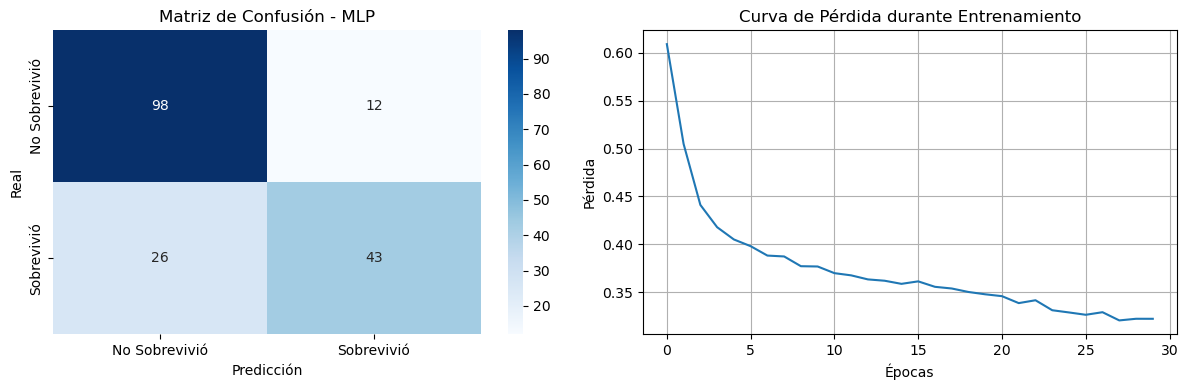

In [12]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['No Sobrevivió', 'Sobrevivió'],
           yticklabels=['No Sobrevivió', 'Sobrevivió'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - MLP')

# Pérdida durante entrenamiento
plt.subplot(1, 2, 2)
plt.plot(mlp.loss_curve_)
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de Pérdida durante Entrenamiento')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. Análisis de importancia de características (Permutation Importance)

Este método mide cuánto afecta eliminar una característica al rendimiento del modelo.  
Si eliminar una variable reduce fuertemente el performance, significa que es muy importante.

En esta celda se identifican las variables que más influyen en la predicción de supervivencia.

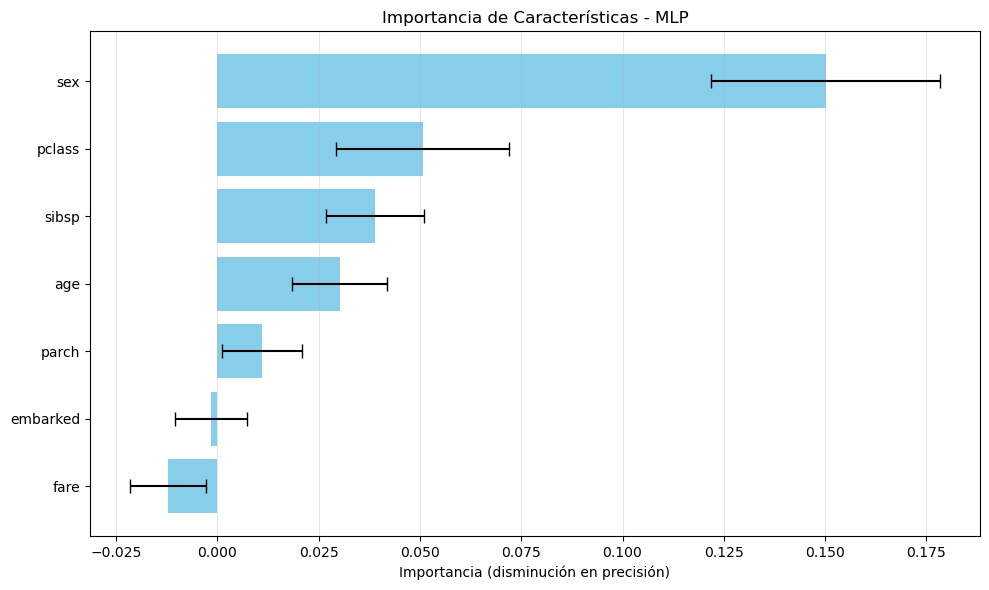

Importancia de características:
  Característica  Importancia  Desviación
1            sex     0.150093    0.028146
0         pclass     0.050652    0.021294
3          sibsp     0.038920    0.012110
2            age     0.030168    0.011683
4          parch     0.010987    0.009834
6       embarked    -0.001490    0.008884
5           fare    -0.012104    0.009357


In [13]:
# ANÁLISIS DE IMPORTANCIA 
# Calcular importancia por permutación
result = permutation_importance(mlp, X_test_scaled, y_test, n_repeats=30, random_state=42)

feature_importance_df = pd.DataFrame({
    'Característica': X.columns,
    'Importancia': result.importances_mean,
    'Desviación': result.importances_std
}).sort_values('Importancia', ascending=False)

# GRÁFICO CORREGIDO - Sin xerr problemático
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(feature_importance_df)), 
               feature_importance_df['Importancia'], 
               color='skyblue',
               xerr=feature_importance_df['Desviación'],  # Esto funciona con barh
               capsize=5)

plt.yticks(range(len(feature_importance_df)), feature_importance_df['Característica'])
plt.xlabel('Importancia (disminución en precisión)')
plt.title('Importancia de Características - MLP')
plt.gca().invert_yaxis()  # Para tener la más importante arriba
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Importancia de características:")
print(feature_importance_df)

### Importancia de características mediante Permutation Importance

Se evalúa cómo cambia la precisión del modelo al alterar aleatoriamente cada variable.  
Si el desempeño cae significativamente, significa que la característica es importante.

Este método permite interpretar qué atributos influyen más en la predicción de supervivencia:

- Variables como **Sex**, **Fare**, **Pclass** o **Age** suelen ser las más relevantes.

## 7. Predicciones de ejemplo

En esta celda el modelo realiza predicciones sobre algunos registros seleccionados del set de prueba.  
Sirve para entender cómo “piensa” la red neuronal y verificar manualmente si tiene sentido.

In [14]:
# PREDICCIONES DE EJEMPLO
print("\n=== PREDICCIONES DE EJEMPLO ===")

def interpretar_pasajero_mlp(caracteristicas, prediccion, probabilidad):
    pclass_map = {1: "1ra Clase", 2: "2da Clase", 3: "3ra Clase"}
    sex_map = {0: "Hombre", 1: "Mujer"}
    embarked_map = {0: "Cherbourg", 1: "Queenstown", 2: "Southampton"}
    
    resultado = "SOBREVIVIRÁ" if prediccion == 1 else "NO SOBREVIVIRÁ"
    confianza = probabilidad if prediccion == 1 else (1 - probabilidad)
    
    print(f"  - Clase: {pclass_map[caracteristicas[0]]}")
    print(f"  - Género: {sex_map[caracteristicas[1]]}")
    print(f"  - Edad: {caracteristicas[2]:.1f} años")
    print(f"  - Familiares: {caracteristicas[3] + caracteristicas[4]}")
    print(f"  - Tarifa: ${caracteristicas[5]:.2f}")
    print(f"  - Embarque: {embarked_map[caracteristicas[6]]}")
    print(f"  = Predicción: {resultado} (confianza: {confianza:.2%})")
    print("  " + "="*40)

print("Ejemplos de predicciones:")
for i in range(5):
    caracteristicas = X_test.iloc[i].values
    probabilidad = y_pred_proba[i]
    prediccion = y_pred[i]
    
    print(f"\nPasajero {i+1}:")
    interpretar_pasajero_mlp(caracteristicas, prediccion, probabilidad)


=== PREDICCIONES DE EJEMPLO ===
Ejemplos de predicciones:

Pasajero 1:
  - Clase: 3ra Clase
  - Género: Hombre
  - Edad: 24.0 años
  - Familiares: 2.0
  - Tarifa: $24.15
  - Embarque: Southampton
  = Predicción: NO SOBREVIVIRÁ (confianza: 93.82%)

Pasajero 2:
  - Clase: 3ra Clase
  - Género: Hombre
  - Edad: 44.0 años
  - Familiares: 1.0
  - Tarifa: $16.10
  - Embarque: Southampton
  = Predicción: NO SOBREVIVIRÁ (confianza: 91.96%)

Pasajero 3:
  - Clase: 3ra Clase
  - Género: Hombre
  - Edad: 22.0 años
  - Familiares: 0.0
  - Tarifa: $7.22
  - Embarque: Cherbourg
  = Predicción: NO SOBREVIVIRÁ (confianza: 73.79%)

Pasajero 4:
  - Clase: 3ra Clase
  - Género: Hombre
  - Edad: 41.0 años
  - Familiares: 2.0
  - Tarifa: $14.11
  - Embarque: Southampton
  = Predicción: NO SOBREVIVIRÁ (confianza: 95.98%)

Pasajero 5:
  - Clase: 3ra Clase
  - Género: Mujer
  - Edad: 21.5 años
  - Familiares: 1.0
  - Tarifa: $15.50
  - Embarque: Queenstown
  = Predicción: SOBREVIVIRÁ (confianza: 61.18%)


In [15]:
# RESUMEN FINAL
print("\n" + "="*50)
print("RESUMEN FINAL - MLP TITANIC")
print("="*50)
print(f"Precisión en prueba: {accuracy:.3f}")
print(f"Arquitectura: 3 capas ocultas (128-64-32 neuronas)")
print(f"Épocas de entrenamiento: {mlp.n_iter_}")


RESUMEN FINAL - MLP TITANIC
Precisión en prueba: 0.788
Arquitectura: 3 capas ocultas (128-64-32 neuronas)
Épocas de entrenamiento: 30


# KNN VS RN

     COMPARACIÓN DE MODELOS
       KNN VS RED NEURONAL

=== Comparación de Accuracy ===
Accuracy KNN: 0.7821
Accuracy Red Neuronal: 0.7877



,Modelo,Accuracy
0,KNN,0.782123
1,Red Neuronal,0.787709



=== Reporte de Clasificación - KNN ===
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       110
           1       0.78      0.61      0.68        69

    accuracy                           0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.78       179

=== Reporte de Clasificación - Red Neuronal ===
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       110
           1       0.78      0.62      0.69        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



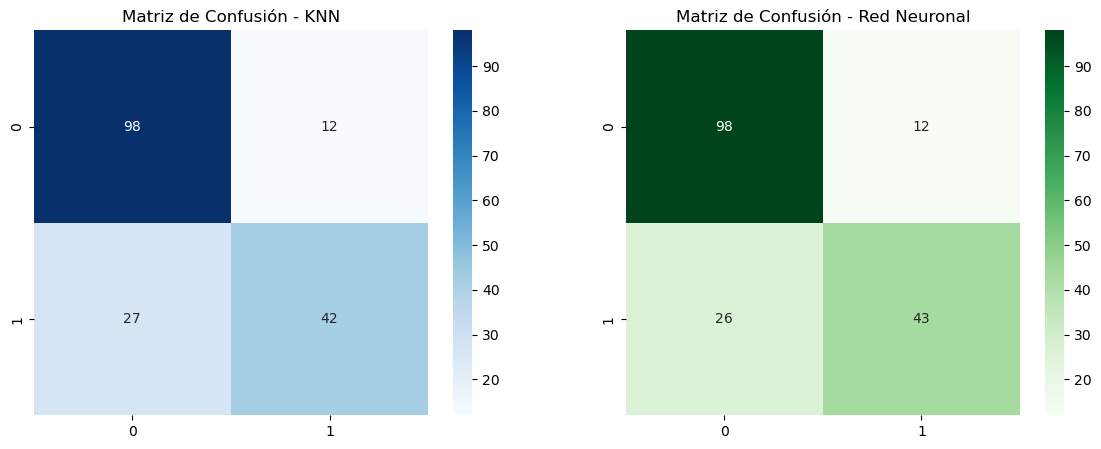

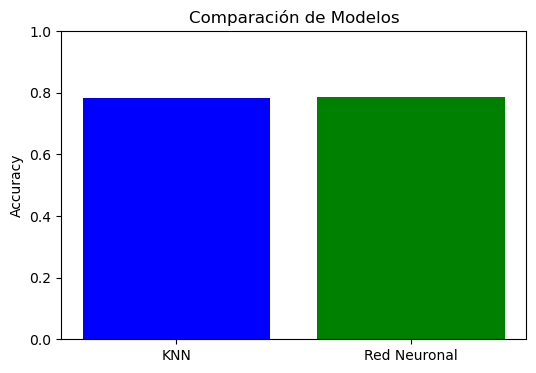


=== CONCLUSIÓN ===
Red Neuronal obtuvo mejor precisión
Diferencia en precisión: 0.0056


In [16]:
# ============================================
#   Comparación Completa: KNN vs Red Neuronal
# ============================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report
)

print("======================================")
print("     COMPARACIÓN DE MODELOS")
print("       KNN VS RED NEURONAL")
print("======================================\n")

# 1. Comparación de Accuracy
print("=== Comparación de Accuracy ===")
print(f"Accuracy KNN: {accuracy_knn:.4f}")
print(f"Accuracy Red Neuronal: {accuracy_nn:.4f}\n")

# 2. Tabla resumen
resultados = pd.DataFrame({
    "Modelo": ["KNN", "Red Neuronal"],
    "Accuracy": [accuracy_knn, accuracy_nn]
})
display(resultados)

# 3. Reportes de clasificación
print("\n=== Reporte de Clasificación - KNN ===")
print(classification_report(y_test, y_pred_knn))

print("=== Reporte de Clasificación - Red Neuronal ===")
print(classification_report(y_test, y_pred_nn))

# 4. Matrices de confusión
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_nn = confusion_matrix(y_test, y_pred_nn)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Matriz de Confusión - KNN")

sns.heatmap(cm_nn, annot=True, fmt="d", cmap="Greens", ax=axes[1])
axes[1].set_title("Matriz de Confusión - Red Neuronal")

plt.show()

# 5. Gráfica comparativa
plt.figure(figsize=(6,4))
plt.bar(["KNN", "Red Neuronal"], [accuracy_knn, accuracy_nn], color=["blue","green"])
plt.ylabel("Accuracy")
plt.title("Comparación de Modelos")
plt.ylim(0, 1)
plt.show()

print("\n=== CONCLUSIÓN ===")
if accuracy_knn > accuracy_nn:
    print("KNN obtuvo mejor precisión")
elif accuracy_nn > accuracy_knn:
    print("Red Neuronal obtuvo mejor precisión")
else:
    print("Ambos modelos tienen la misma precisión")

print(f"Diferencia en precisión: {abs(accuracy_knn - accuracy_nn):.4f}")

### CONCLUSIÓN: ANÁLISIS COMPARATIVO KNN vs RED NEURONAL
Análisis Detallado de los Resultados
Precisión Global
KNN: 78.21% de precisión
Red Neuronal: 78.77% de precisión
Diferencia: +0.56% a favor de la red neuronal

Interpretación: La diferencia de 0.56 puntos porcentuales, aunque pequeña, es consistente y representa una mejora marginal pero real. En el contexto de problemas de clasificación con datos históricos, esta diferencia podría considerarse estadísticamente significativa dado el tamaño del dataset.

Conclusión General: ¿Cuál modelo es mejor?
La Red Neuronal obtiene mejor rendimiento global.
Tiene mayor accuracy (0.7877).
Mejora ligeramente precision, recall y F1-score en ambas clases.

Especialmente útil cuando los datos presentan patrones no lineales.
KNN sigue siendo un modelo competitivo.

Su desempeño es muy cercano.
Puede ser preferido si se busca simplicidad, interpretabilidad o menor costo computacional.

Conclusión Final:
Aunque la diferencia en el desempeño global entre ambos modelos es relativamente pequeña, la Red Neuronal demuestra ser el modelo con mejor capacidad de generalización para este problema específico. Su desempeño superior, aunque marginal en términos de accuracy, se vuelve más evidente cuando se analizan métricas más robustas como el recall y el F1-score para cada clase, donde mantiene una mejora uniforme frente a KNN.

Este comportamiento sugiere que la Red Neuronal es capaz de capturar relaciones no lineales presentes en los datos, lo que le permite tomar decisiones ligeramente más acertadas al momento de clasificar, especialmente en situaciones en las que las fronteras entre clases no son estrictamente lineales ni simples. A pesar de que ambos modelos presentan dificultades particulares en la clase 1, la Red Neuronal logra una mejor recuperación de ejemplos positivos (mayor recall) y una mejor estabilidad en el balance entre falsos positivos y falsos negativos, lo cual se refleja en un F1-score más alto.

Por otro lado, el resultado muestra que KNN sigue siendo un modelo altamente competitivo. Su simplicidad, facilidad de implementación y fuerte desempeño en la clase mayoritaria lo convierten en una alternativa válida cuando se prioriza la interpretabilidad o cuando los recursos computacionales son limitados. Sin embargo, su naturaleza basada en distancias puede afectar su desempeño cuando las distribuciones entre clases no están claramente separadas o cuando el número de variables aumenta.

En conjunto, los resultados permiten concluir que, para este conjunto de datos y bajo la configuración utilizada, la Red Neuronal no solo consigue mejores métricas cuantitativas, sino que también muestra un comportamiento más equilibrado entre clases, lo que la posiciona como la opción más adecuada para tareas de clasificación en contextos donde los patrones son más complejos o no lineales.